In [ ]:
!pip install geopandas deap shapely pyproj cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
# Data handling and manipulation
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from pyproj import Transformer

# Visualization
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Genetic Algorithm
from deap import base, creator, tools, algorithms
import random
from random import uniform
from scipy.spatial import KDTree
import numpy as np
import itertools
import time
from scipy.spatial import KDTree
from itertools import product
import pickle

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Data Preprocessing

Preprocessing Functions

In [ ]:
def load_data(parquet_path, shapefile_path):
    """
    Load performance data from a Parquet file and geospatial data from a shapefile.
    """
    performance_data = pd.read_parquet(parquet_path)
    geo_data = gpd.read_file(shapefile_path)

    return performance_data, geo_data


def merge_data(performance_data, geo_data):
    """
    Merge performance data with geospatial data using 'quadkey' as the key.
    """
    merged_data = geo_data.merge(performance_data, on='quadkey', how='inner')

    return merged_data


def rename_and_filter_columns(data):
    """
    Rename specific columns and retain only the necessary ones for analysis.
    """
    data.rename(columns={
        'avg_d_kbps_x': 'avg_d_kbps',
        'avg_u_kbps_x': 'avg_u_kbps',
        'avg_lat_ms_x': 'avg_lat_ms',
        'tests_x': 'tests',
        'devices_x': 'devices'
    }, inplace=True)

    data = data[['geometry', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices']].copy()

    return data


def reproject_data(data):
    """
    Reproject geospatial data to EPSG:3857 coordinate reference system.
    """
    data = data.to_crs(epsg=3857)

    return data


def add_centroids_and_transform(data):
    """
    Add centroids of geometries and transform coordinates from EPSG:3857 to EPSG:4326.
    """
    data['centroid'] = data.geometry.centroid

    transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    data["lat"], data["lon"] = zip(
        *data["centroid"].apply(lambda p: transformer.transform(p.x, p.y)))

    return data


def filter_data(data):
    """
    Filter out invalid coordinates and rows with missing or invalid data.
    """
    data = data[
        (data['lat'] >= 35) & (data['lat'] <= 60) &
        (data['lon'] >= 20) & (data['lon'] <= 70)
    ]

    data = data.dropna(subset=['lat', 'lon', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'devices'])

    return data


def feature_engineering(data):
    """
    Create new features like bandwidth efficiency, total bandwidth, and latency per device.
    """
    data['bandwidth_efficiency'] = data.apply(
        lambda row: row['avg_u_kbps'] / row['avg_d_kbps'] if row['avg_d_kbps'] != 0 else 0, axis=1)

    data['total_bandwidth'] = data['avg_u_kbps'] + data['avg_d_kbps']

    data['latency_per_device'] = data.apply(
        lambda row: row['avg_lat_ms'] / row['devices'] if row['devices'] != 0 else row['avg_lat_ms'], axis=1)

    data['tests_per_device'] = data.apply(
        lambda row: row['tests'] / row['devices'] if row['devices'] != 0 else row['tests'], axis=1)

    data['polygon_area'] = data['geometry'].apply(lambda x: shape(x).area)
    data['polygon_perimeter'] = data['geometry'].apply(lambda x: shape(x).length)

    data['spatial_cluster'] = data['centroid'].apply(
        lambda c: (round(c.x, -2), round(c.y, -2)))

    return data


def world_map(data):
    """
    Plot the selected coordinates on a world map.
    """
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')

    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    ax.scatter(
        data['lon'],
        data['lat'],
        color='red',
        s=10,
        transform=ccrs.PlateCarree(),
        label="Selected Data Coordinates"
    )

    ax.set_title("Data coordinates on the World Map", fontsize=16)
    ax.legend()

    plt.show()

Preprocessing Steps

In [ ]:
# # File paths
# parquet_path = 'D:/Nammi Wade/IIT/4th Year/CI CW/2019-01-01_performance_mobile_tiles.parquet'
# shapefile_path = 'D:/Nammi Wade/IIT/4th Year/CI CW/20219-01-01_performance_mobile_tiles.zip'

In [ ]:
# File paths
parquet_path = '/content/drive/My Drive/CI/OoklaData/parquet/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.parquet'
shapefile_path = '/content/drive/MyDrive/CI/OoklaData/shapefiles/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.zip'

In [ ]:
# Load Data
performance_data, geo_data = load_data(parquet_path, shapefile_path)

In [ ]:
# Merge Data
merged_data = merge_data(performance_data, geo_data)

In [ ]:
# Rename and Filter Columns
renamed_data = rename_and_filter_columns(merged_data)

In [ ]:
# Reproject Data
reproject_data = reproject_data(renamed_data)

In [ ]:
# Add Centroids and Transform Coordinates
centroids_and_transform_added_data = add_centroids_and_transform(reproject_data)

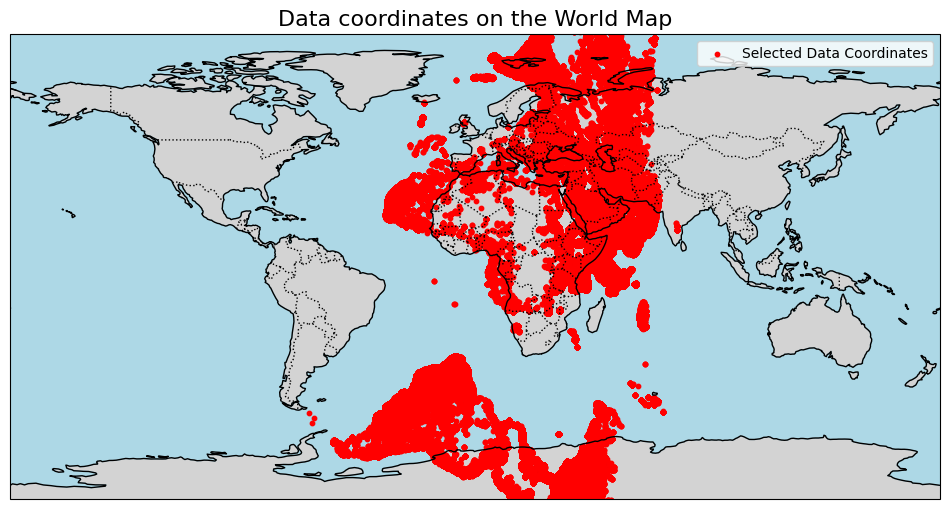

In [ ]:
# Map the World Coordinates
world_map(centroids_and_transform_added_data)

In [ ]:
# Filter Missing and Irrelavent Data
filtered_data = filter_data(centroids_and_transform_added_data)

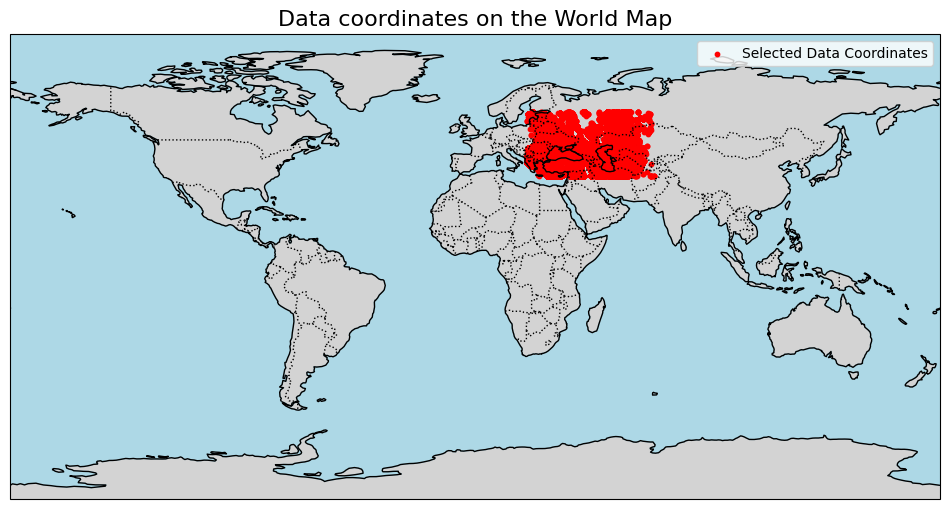

In [ ]:
# Map the World Coordinates
world_map(filtered_data)

In [ ]:
# Feature Engineering
preprocessed_data = feature_engineering(filtered_data)

Exploratory Data Analysis

In [ ]:
# Display the preprocessed data
preprocessed_data.head()

,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,centroid,lat,lon,bandwidth_efficiency,total_bandwidth,latency_per_device,tests_per_device,polygon_area,polygon_perimeter,spatial_cluster
26,"POLYGON ((6137587.623 2885039.196, 6138199.119...",37923,13036,9,822,342,POINT (6137893.371 2884733.447),55.137634,25.073161,0.343749,50959,0.026316,2.403509,373927.634755,2445.984905,"(6137900.0, 2884700.0)"
37,"POLYGON ((3948431.133 4684061.093, 3949042.629...",25548,6398,9,26,14,POINT (3948736.881 4683755.345),35.472107,38.734804,0.250431,31946,0.642857,1.857143,373927.634758,2445.984905,"(3948700.0, 4683800.0)"
47,"POLYGON ((5197106.427 2855687.377, 5197717.923...",53194,23948,13,150,36,POINT (5197412.175 2855381.629),46.689148,24.834103,0.450201,77142,0.361111,4.166667,373927.634757,2445.984905,"(5197400.0, 2855400.0)"
89,"POLYGON ((6141868.097 2887485.181, 6142479.593...",27745,9718,10,630,228,POINT (6142173.845 2887179.432),55.176086,25.093061,0.350261,37463,0.043860,2.763158,373927.634753,2445.984905,"(6142200.0, 2887200.0)"
119,"POLYGON ((4032206.116 6448227.706, 4032817.612...",37827,38943,5,212,52,POINT (4032511.864 6447921.958),36.224670,50.009504,1.029503,76770,0.096154,4.076923,373927.634751,2445.984905,"(4032500.0, 6447900.0)"


In [ ]:
# Generate summary statistics for numerical columns in the dataset
preprocessed_data.describe()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,lat,lon,bandwidth_efficiency,total_bandwidth,latency_per_device,tests_per_device,polygon_area,polygon_perimeter
count,317025.000000,317025.000000,317025.000000,317025.000000,317025.000000,317025.000000,317025.000000,317025.000000,3.170250e+05,317025.000000,317025.000000,317025.000000,3.170250e+05
mean,23121.488640,19000.765107,45.230979,18.412816,5.847548,43.547421,41.873045,1.521939,4.212225e+04,33.102077,2.662719,373927.634756,2.445985e+03
std,26198.107557,24240.000046,145.685485,54.415682,15.233209,6.542868,12.397454,45.174229,4.774554e+04,137.830031,5.383162,0.000004,1.351973e-08
min,1.000000,1.000000,0.000000,1.000000,1.000000,35.005188,20.001741,0.000014,5.000000e+00,0.000000,1.000000,373927.634738,2.445985e+03
25%,5975.000000,2892.000000,9.000000,1.000000,1.000000,37.751770,29.914472,0.350188,1.002000e+04,3.000000,1.000000,373927.634754,2.445985e+03
50%,15563.000000,10041.000000,25.000000,3.000000,1.000000,42.118835,43.395070,0.803041,2.684200e+04,11.000000,1.500000,373927.634756,2.445985e+03
75%,32937.000000,28143.000000,47.000000,11.000000,4.000000,48.139343,54.890826,1.134681,6.090400e+04,34.000000,2.857143,373927.634759,2.445985e+03
max,641388.000000,584120.000000,39598.000000,2256.000000,1256.000000,59.999084,69.190873,15292.333333,1.140538e+06,39598.000000,775.000000,373927.634773,2.445985e+03


In [ ]:
# Print a concise summary of the dataset
preprocessed_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 317025 entries, 26 to 4877008
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   geometry              317025 non-null  geometry
 1   avg_d_kbps            317025 non-null  int32   
 2   avg_u_kbps            317025 non-null  int32   
 3   avg_lat_ms            317025 non-null  int32   
 4   tests                 317025 non-null  int32   
 5   devices               317025 non-null  int32   
 6   centroid              317025 non-null  geometry
 7   lat                   317025 non-null  float64 
 8   lon                   317025 non-null  float64 
 9   bandwidth_efficiency  317025 non-null  float64 
 10  total_bandwidth       317025 non-null  int32   
 11  latency_per_device    317025 non-null  float64 
 12  tests_per_device      317025 non-null  float64 
 13  polygon_area          317025 non-null  float64 
 14  polygon_perimeter     317025 no

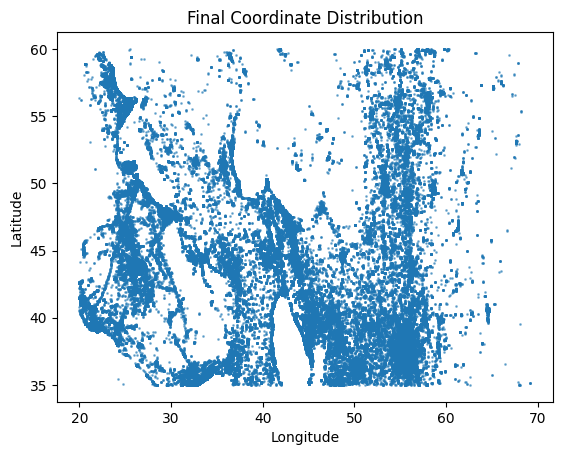

In [ ]:
# Plot a scatter plot of preprocessed latitude and longitude coordinates
plt.scatter(preprocessed_data['lon'], preprocessed_data['lat'], s=1, alpha=0.5)
plt.title("Final Coordinate Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# preprocessed_data = preprocessed_data.head(1000)

### Machine Learning

Target Variable Creation

In [ ]:
regression_data = preprocessed_data.reset_index(drop=True)

In [ ]:
features = ['devices', 'total_bandwidth', 'avg_lat_ms']
regression_data = regression_data.copy()

scaled_data = StandardScaler().fit_transform(regression_data[features].copy())

pca = PCA(n_components=1)
regression_data.loc[:, 'latent_demand'] = pca.fit_transform(scaled_data)

In [ ]:
regression_data.head()

,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,centroid,lat,lon,bandwidth_efficiency,total_bandwidth,latency_per_device,tests_per_device,polygon_area,polygon_perimeter,spatial_cluster,latent_demand
0,"POLYGON ((6137587.623 2885039.196, 6138199.119...",37923,13036,9,822,342,POINT (6137893.371 2884733.447),55.137634,25.073161,0.343749,50959,0.026316,2.403509,373927.634755,2445.984905,"(6137900.0, 2884700.0)",11.082415
1,"POLYGON ((3948431.133 4684061.093, 3949042.629...",25548,6398,9,26,14,POINT (3948736.881 4683755.345),35.472107,38.734804,0.250431,31946,0.642857,1.857143,373927.634758,2445.984905,"(3948700.0, 4683800.0)",0.258437
2,"POLYGON ((5197106.427 2855687.377, 5197717.923...",53194,23948,13,150,36,POINT (5197412.175 2855381.629),46.689148,24.834103,0.450201,77142,0.361111,4.166667,373927.634757,2445.984905,"(5197400.0, 2855400.0)",1.585064
3,"POLYGON ((6141868.097 2887485.181, 6142479.593...",27745,9718,10,630,228,POINT (6142173.845 2887179.432),55.176086,25.093061,0.350261,37463,0.043860,2.763158,373927.634753,2445.984905,"(6142200.0, 2887200.0)",7.219998
4,"POLYGON ((4032206.116 6448227.706, 4032817.612...",37827,38943,5,212,52,POINT (4032511.864 6447921.958),36.224670,50.009504,1.029503,76770,0.096154,4.076923,373927.634751,2445.984905,"(4032500.0, 6447900.0)",2.125475


Regression Model

In [ ]:
# Features and Target
X = regression_data.select_dtypes(include=[np.number]).drop(columns=['latent_demand'])
y = regression_data['latent_demand']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict on Test Data
y_pred = model.predict(X_test)

Evaluate Regression Model

In [ ]:
# Evaluate model performance using MAE, MSE, and R² metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}, MSE: {mse}, R²: {r2}")

MAE: 0.003551114892331346, MSE: 0.0017658862606760126, R²: 0.9984420922544736


Predict latent demand for the entire dataset

In [ ]:
regression_data['predicted_latent_demand'] = model.predict(X)

In [ ]:
regression_data.head()

,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,centroid,lat,lon,bandwidth_efficiency,total_bandwidth,latency_per_device,tests_per_device,polygon_area,polygon_perimeter,spatial_cluster,latent_demand,predicted_latent_demand
0,"POLYGON ((6137587.623 2885039.196, 6138199.119...",37923,13036,9,822,342,POINT (6137893.371 2884733.447),55.137634,25.073161,0.343749,50959,0.026316,2.403509,373927.634755,2445.984905,"(6137900.0, 2884700.0)",11.082415,11.040715
1,"POLYGON ((3948431.133 4684061.093, 3949042.629...",25548,6398,9,26,14,POINT (3948736.881 4683755.345),35.472107,38.734804,0.250431,31946,0.642857,1.857143,373927.634758,2445.984905,"(3948700.0, 4683800.0)",0.258437,0.257582
2,"POLYGON ((5197106.427 2855687.377, 5197717.923...",53194,23948,13,150,36,POINT (5197412.175 2855381.629),46.689148,24.834103,0.450201,77142,0.361111,4.166667,373927.634757,2445.984905,"(5197400.0, 2855400.0)",1.585064,1.592106
3,"POLYGON ((6141868.097 2887485.181, 6142479.593...",27745,9718,10,630,228,POINT (6142173.845 2887179.432),55.176086,25.093061,0.350261,37463,0.043860,2.763158,373927.634753,2445.984905,"(6142200.0, 2887200.0)",7.219998,7.156753
4,"POLYGON ((4032206.116 6448227.706, 4032817.612...",37827,38943,5,212,52,POINT (4032511.864 6447921.958),36.224670,50.009504,1.029503,76770,0.096154,4.076923,373927.634751,2445.984905,"(4032500.0, 6447900.0)",2.125475,2.109467


Visualize the predicted demand

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


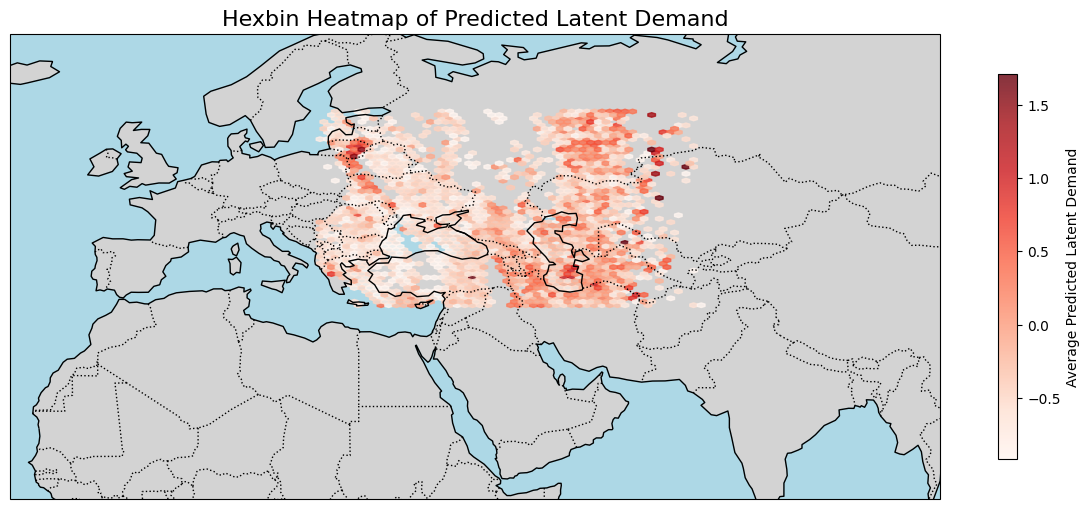

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')

vmin, vmax = regression_data['predicted_latent_demand'].quantile(0.05), regression_data['predicted_latent_demand'].quantile(0.95)

hb = ax.hexbin(
    regression_data['lon'], regression_data['lat'], C=regression_data['latent_demand'],
    gridsize=50, reduce_C_function=np.mean, cmap='Reds',
    vmin=vmin, vmax=vmax, alpha=0.8, transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(hb, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label("Average Predicted Latent Demand")

ax.set_title("Hexbin Heatmap of Predicted Latent Demand", fontsize=16)
ax.set_extent([-20, 100, 10, 70], crs=ccrs.PlateCarree())

plt.show()

### Genetic Algorithm

In [ ]:
# file_path = '/content/drive/MyDrive/CI/regression_data.csv'
# # file_path = "D:/Nammi Wade/IIT/4th Year/CI CW/regression_data.csv"

# regression_data = pd.read_csv(file_path)
# # regression_data = regression_data.head(1000)

Objective 1: Maximize Network Coverage

In [ ]:
def maximize_coverage(solution, data):
    """
    Calculate the total coverage provided by towers placed at specified coordinates.
    """
    total_coverage = 0

    for i in range(0, len(solution), 2):
        lat, lon = solution[i], solution[i + 1]
        if lat is None or lon is None:
            continue

        distances = (data['lat'] - lat)**2 + (data['lon'] - lon)**2
        closest_data_idx = distances.values.argmin()
        closest_data = data.iloc[closest_data_idx]

        total_coverage += closest_data['predicted_latent_demand'] * closest_data['polygon_area']

    return total_coverage

Objective 2: Minimize Infrastructure Cost

In [ ]:
def minimize_cost(solution, cost_per_tower):
    """
    Minimize infrastructure cost by reducing the number of towers.
    """
    active_towers = sum(1 for i in range(0, len(solution), 2) if solution[i] is not None)

    return active_towers * cost_per_tower


Objective 3: Maximize Network Performance

In [ ]:
def maximize_performance(solution, data):
    """
    Maximize network performance based on lat/lon tower placements.
    """
    performance = 0
    for i in range(0, len(solution), 2):
        lat, lon = solution[i], solution[i + 1]
        if lat is None or lon is None:
            continue

        distances = (data['lat'] - lat)**2 + (data['lon'] - lon)**2
        closest_data_idx = distances.values.argmin()
        closest_data = data.iloc[closest_data_idx]

        performance += (
            closest_data['bandwidth_efficiency'] *
            closest_data['total_bandwidth'] /
            (1 + closest_data['avg_lat_ms'])
        )

    return performance

Objective 4: Minimize Overlap

In [ ]:
def minimize_tower_overlap(solution, tower_radius):
    """
    Calculate the total overlap area of towers based on their coverage regions.
    """
    coords = [(solution[i], solution[i + 1]) for i in range(0, len(solution), 2)
              if solution[i] is not None and solution[i + 1] is not None]

    if len(coords) < 2:
        return 0

    tree = KDTree(coords)
    pairs = tree.query_pairs(2 * tower_radius)

    total_overlap_area = 0
    for i, j in pairs:
        distance = np.linalg.norm(np.subtract(coords[i], coords[j]))
        if distance < 2 * tower_radius:
            total_overlap_area += circular_overlap_area(tower_radius, tower_radius, distance)

    return total_overlap_area


def circular_overlap_area(r1, r2, d):
    """
    Calculate the overlap area between two circles of radii r1 and r2 separated by distance d.
    """
    if d >= r1 + r2:
        return 0
    elif d <= abs(r1 - r2):
        return np.pi * min(r1, r2)**2
    else:
        r1_sq = r1**2
        r2_sq = r2**2
        part1 = r1_sq * np.arccos((d**2 + r1_sq - r2_sq) / (2 * d * r1))
        part2 = r2_sq * np.arccos((d**2 + r2_sq - r1_sq) / (2 * d * r2))
        part3 = 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))

        return part1 + part2 - part3

Constraint 1: Geographic Constraints

In [ ]:
def geographic_constraints(solution, min_lat, max_lat, min_lon, max_lon):
    """
    Ensure all tower coordinates stay within the specified latitude and longitude bounds.
    """
    for i in range(0, len(solution), 2):
        lat, lon = solution[i], solution[i + 1]
        if lat is None or lon is None:
            continue
        if not (min_lat <= lat <= max_lat) or not (min_lon <= lon <= max_lon):
            return False

    return True

Fitness Evaluation Function

In [ ]:
def evaluate(individual, data, weights, cost_per_tower, constraints_params):
    """
    Evaluate the fitness of an individual solution based on multiple objectives and constraints.
    """
    w_coverage = weights.get("coverage")
    w_cost = weights.get("cost")
    w_performance = weights.get("performance")
    w_overlap = weights.get("overlap")

    coverage_score = maximize_coverage(individual, data)
    cost_score = minimize_cost(individual, cost_per_tower)
    performance_score = maximize_performance(individual, data)
    overlap_score = minimize_tower_overlap(individual, constraints_params.get("tower_radius"))

    fitness = (
        w_coverage * coverage_score +
        w_performance * performance_score -
        w_cost * cost_score -
        w_overlap * overlap_score
    )

    if not geographic_constraints(
        individual,
        constraints_params["min_lat"],
        constraints_params["max_lat"],
        constraints_params["min_lon"],
        constraints_params["max_lon"]
    ):
        fitness -= constraints_params.get("geographic_penalty")

    return fitness,

Crossover Function

In [ ]:
def safe_crossover(ind1, ind2, min_lat=35, max_lat=60, min_lon=20, max_lon=70):
    """
    Custom crossover function to handle None values and enforce bounds with Blend Crossover.
    """
    dummy_value = 0.0
    for i in range(len(ind1)):
        if ind1[i] is None: ind1[i] = dummy_value
        if ind2[i] is None: ind2[i] = dummy_value

    tools.cxBlend(ind1, ind2, alpha=0.5)

    for i in range(0, len(ind1), 2):
        ind1[i] = max(min_lat, min(ind1[i], max_lat))
        ind1[i + 1] = max(min_lon, min(ind1[i + 1], max_lon))
        ind2[i] = max(min_lat, min(ind2[i], max_lat))
        ind2[i + 1] = max(min_lon, min(ind2[i + 1], max_lon))

    return ind1, ind2

Mutation Function

In [ ]:
def mutate_towers(individual, min_lat, max_lat, min_lon, max_lon):
    """
    Mutation operator to move towers randomly within bounds.
    """
    for i in range(0, len(individual), 2):
        if random.random() < 0.3:
            individual[i] = None
            individual[i + 1] = None
        elif random.random() < 0.3:
            individual[i] = uniform(min_lat, max_lat)
            individual[i + 1] = uniform(min_lon, max_lon)
        else:
            if individual[i] is not None:
                individual[i] = max(min_lat, min(individual[i], max_lat))
            if individual[i + 1] is not None:
                individual[i + 1] = max(min_lon, min(individual[i + 1], max_lon))
    return individual,

Individual Creation Function

In [ ]:
def generate_individual(max_towers, min_lat, max_lat, min_lon, max_lon):
    """
    Generate an individual with up to max_towers towers.
    Each individual always starts with max_towers latitude-longitude pairs.
    """
    individual = []
    for _ in range(max_towers):
        lat = uniform(min_lat, max_lat)
        lon = uniform(min_lon, max_lon)
        individual.extend([lat, lon])

    return creator.Individual(individual)

GA Setup Function

In [ ]:
def setup_ga(max_towers, data, weights, cost_per_tower, constraints_params):
    """
    Set up the DEAP GA components for optimization.
    """
    if "FitnessMax" not in creator.__dict__:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    min_lat = constraints_params['min_lat']
    max_lat = constraints_params['max_lat']
    min_lon = constraints_params['min_lon']
    max_lon = constraints_params['max_lon']

    toolbox.register("attr_lat", lambda: uniform(min_lat, max_lat))
    toolbox.register("attr_lon", lambda: uniform(min_lon, max_lon))
    toolbox.register("individual", generate_individual, max_towers, min_lat, max_lat, min_lon, max_lon)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate, data=data, weights=weights, cost_per_tower=cost_per_tower, constraints_params=constraints_params)
    toolbox.register("mate", safe_crossover, min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)
    toolbox.register("mutate", lambda ind: mutate_towers(ind, min_lat, max_lat, min_lon, max_lon))

    return toolbox

Run GA Function

In [ ]:
def run_ga(toolbox, generations, pop_size, offspring_size, cxpb, mutpb, verbose):
    """
    Run the Genetic Algorithm.
    """
    population = toolbox.population(n=pop_size)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("mean", np.mean)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals", "min", "max", "mean"]
    hof = tools.HallOfFame(1)

    population, logbook = algorithms.eaMuPlusLambda(
        population,
        toolbox,
        mu=pop_size,
        lambda_=offspring_size,
        cxpb=cxpb,
        mutpb=mutpb,
        ngen=generations,
        stats=stats,
        halloffame=hof,
        verbose=verbose,
    )

    return population, logbook, hof

Calculate Max Towers and Tower Radius

In [ ]:
# Calculate max towers
grid_size = 0.5
lat_bins = np.arange(regression_data['lat'].min(), regression_data['lat'].max(), grid_size)
lon_bins = np.arange(regression_data['lon'].min(), regression_data['lon'].max(), grid_size)

regression_data['lat_bin'] = np.digitize(regression_data['lat'], lat_bins)
regression_data['lon_bin'] = np.digitize(regression_data['lon'], lon_bins)

grid_demand = regression_data.groupby(['lat_bin', 'lon_bin'])['predicted_latent_demand'].mean().reset_index()
significant_cells = grid_demand[grid_demand['predicted_latent_demand'] > 0.75]

max_towers = len(significant_cells)
print(f"Estimated Max Towers: {max_towers}")

Estimated Max Towers: 31


In [ ]:
# Calculate tower radius
coords = list(zip(regression_data['lat'], regression_data['lon']))
tree = KDTree(coords)
distances, _ = tree.query(coords, k=2)
avg_distance = distances[:, 1].mean()

tower_radius = avg_distance * 111 / 2
print(f"Estimated Tower Radius: {tower_radius:.2f} km")

Estimated Tower Radius: 0.41 km


Parameter Initialization and GA Setup

In [ ]:
max_towers = 35
cost_per_tower = 10000

weights = {
    "coverage": 1.0,
    "cost": 0.2,
    "performance": 0.7,
    "overlap": 0.6
}

constraints_params = {
    "min_lat": regression_data['lat'].min(),
    "max_lat": regression_data['lat'].max(),
    "min_lon": regression_data['lon'].min(),
    "max_lon": regression_data['lon'].max(),
    "geographic_penalty": 100000,
    "tower_radius": 0.5
}

toolbox = setup_ga(max_towers, regression_data, weights, cost_per_tower, constraints_params)

GA Execution

In [25]:
start_time = time.time()
population, logbook, hof = run_ga(toolbox, generations=100, pop_size=50, offspring_size=50, cxpb=0.6, mutpb=0.2, verbose=True)
end_time = time.time()

best_individual = hof[0]

tower_coordinates = [
    (best_individual[i], best_individual[i + 1])
    for i in range(0, len(best_individual), 2)
    if best_individual[i] is not None and best_individual[i + 1] is not None
]

num_towers = len(tower_coordinates)

print(f"Best Fitness: {best_individual.fitness.values[0]}")
print(f"Number of Active Towers: {num_towers}")
print(f"Tower Coordinates: {tower_coordinates}")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

gen	nevals	min         	max        	mean        
0  	50    	-1.34848e+07	-3.6173e+06	-8.42055e+06
1  	44    	-1.11813e+07	-3.6173e+06	-6.40608e+06
2  	32    	-8.55356e+06	-2.05444e+06	-4.89437e+06
3  	42    	-7.58235e+06	-2.05444e+06	-4.38022e+06
4  	42    	-9.95381e+06	-1.9979e+06 	-4.11628e+06
5  	41    	-8.24021e+06	-822079     	-3.34286e+06
6  	41    	-6.82378e+06	-822079     	-2.96689e+06
7  	36    	-5.55239e+06	-822079     	-2.38685e+06
8  	39    	-6.03249e+06	-822079     	-2.21414e+06
9  	36    	-6.03249e+06	-442002     	-1.87168e+06
10 	35    	-4.88321e+06	-346900     	-1.59455e+06
11 	43    	-7.36276e+06	-346900     	-1.90097e+06
12 	38    	-8.9724e+06 	-346900     	-1.55559e+06
13 	45    	-6.43232e+06	-346900     	-1.19746e+06
14 	44    	-2.94022e+06	-346900     	-619162     
15 	36    	-4.48003e+06	-346900     	-605871     
16 	41    	-6.28522e+06	141777      	-690291     
17 	41    	-6.28522e+06	141777      	-520076     
18 	37    	-6.28522e+06	141777      	-383035     
19 

Visualizing Tower Coordinates

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/

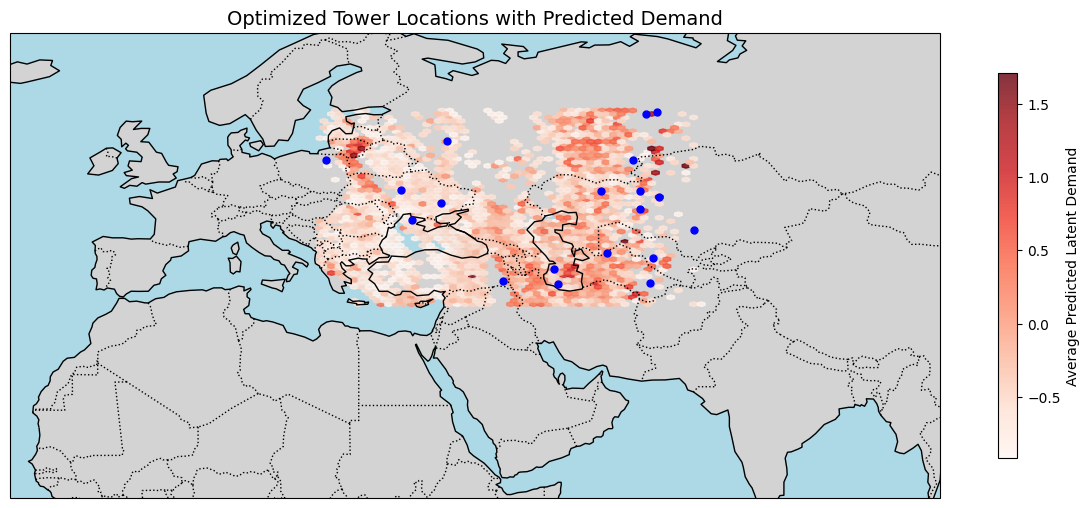

In [26]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')

region_extent = [-20, 100, 10, 70]
ax.set_extent(region_extent, crs=ccrs.PlateCarree())

vmin = regression_data['predicted_latent_demand'].quantile(0.05)
vmax = regression_data['predicted_latent_demand'].quantile(0.95)

hb = ax.hexbin(
    regression_data['lon'],
    regression_data['lat'],
    C=regression_data['predicted_latent_demand'],
    gridsize=50,
    reduce_C_function=np.mean,
    cmap="Reds",
    vmin=vmin,
    vmax=vmax,
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

for lat, lon in tower_coordinates:
    ax.plot(lon, lat, 'bo', markersize=5, transform=ccrs.PlateCarree(), label="Tower Location")

cbar = plt.colorbar(hb, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label("Average Predicted Latent Demand")

ax.set_title("Optimized Tower Locations with Predicted Demand", fontsize=14)
ax.set_extent([-20, 100, 10, 70], crs=ccrs.PlateCarree())

plt.show()

GA Evaluation

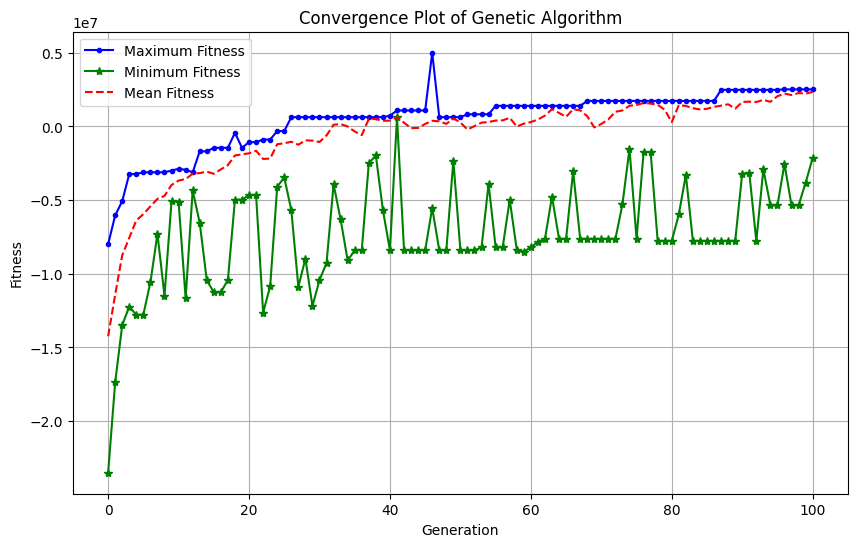

In [ ]:
# Plot convergence after running the GA
generations = logbook.select("gen")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")
mean_fitness = logbook.select("mean")

plt.figure(figsize=(10, 6))
plt.plot(generations, max_fitness, label="Maximum Fitness", marker=".", color="b")
plt.plot(generations, min_fitness, label="Minimum Fitness", marker="*", color="g")
plt.plot(generations, mean_fitness, label="Mean Fitness", linestyle="--", color="r")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Convergence Plot of Genetic Algorithm")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Run GA multiple times and evaluate results
evaluation_counts = []
best_fitness_results = []
num_trials = 10

for run in range(num_trials):
    print(f"Run {run + 1}:")
    population, logbook, hof = run_ga(
        toolbox=toolbox,
        generations=100,
        pop_size=50,
        offspring_size=50,
        cxpb=0.6,
        mutpb=0.2,
        verbose=False
    )

    total_evaluations = sum(logbook.select("nevals"))
    evaluation_counts.append(total_evaluations)

    best_fitness = hof[0].fitness.values[0]
    best_fitness_results.append(best_fitness)

    print(f"  Best Fitness: {best_fitness:.2f}")
    print(f"  Total Evaluations: {total_evaluations}")

mean_best_fitness = np.mean(best_fitness_results)
average_evaluations = np.mean(evaluation_counts)

print("\n--- Final Metrics ---")
print(f"Mean Best Fitness: {mean_best_fitness:.2f}")
print(f"Average Evaluations to Solution: {average_evaluations:.2f}")

Run 1:
  Best Fitness: 7047642.93
  Total Evaluations: 4059
Run 2:
  Best Fitness: 10158742.59
  Total Evaluations: 4048
Run 3:
  Best Fitness: 8320820.24
  Total Evaluations: 4091
Run 4:
  Best Fitness: 9041605.56
  Total Evaluations: 4026
Run 5:
  Best Fitness: 7524980.09
  Total Evaluations: 4039
Run 6:
  Best Fitness: 7813939.49
  Total Evaluations: 4022
Run 7:
  Best Fitness: 5047005.88
  Total Evaluations: 4055
Run 8:
  Best Fitness: 3749624.53
  Total Evaluations: 4079
Run 9:
  Best Fitness: 5028961.15
  Total Evaluations: 4027
Run 10:
  Best Fitness: 4660518.50
  Total Evaluations: 4066

--- Final Metrics ---
Mean Best Fitness: 6839384.10
Average Evaluations to Solution: 4051.20


Hyperparameter Tunning

In [20]:
def hyperparameter_search(toolbox, param_grid, save_path="Parameter_tuning_results.pkl"):
    """
    Perform hyperparameter search and save the results.
    """
    results = []
    runs = []

    for params in product(*param_grid.values()):
        generations, pop_size, offspring_size, cxpb, mutpb = params

        population, logbook, hof = run_ga(
            toolbox,
            generations=generations,
            pop_size=pop_size,
            offspring_size=offspring_size,
            cxpb=cxpb,
            mutpb=mutpb,
            verbose=False
        )

        best_fitness = hof[0].fitness.values[0]
        total_evaluations = sum(record['nevals'] for record in logbook)

        results.append((params, best_fitness))
        runs.append({
            "params": params,
            "best_fitness": best_fitness,
            "evaluations": total_evaluations,
            "logbook": logbook
        })

        print(f"Parameters: {params}, Best Fitness: {best_fitness}")

    with open(save_path, "wb") as f:
        pickle.dump(runs, f)

    print(f"Tuning results saved to {save_path}")
    return results

In [21]:
max_towers = 35
cost_per_tower = 10000

weights = {
    "coverage": 1.0,
    "cost": 0.2,
    "performance": 0.7,
    "overlap": 0.6
}

constraints_params = {
    "min_lat": regression_data['lat'].min(),
    "max_lat": regression_data['lat'].max(),
    "min_lon": regression_data['lon'].min(),
    "max_lon": regression_data['lon'].max(),
    "geographic_penalty": 100000,
    "tower_radius": 0.5
}

toolbox = setup_ga(max_towers=max_towers, data=regression_data, weights=weights, cost_per_tower=cost_per_tower, constraints_params=constraints_params)

In [22]:
param_grid = {
    "generations": [50],
    "pop_size": [50],
    "offspring_size": [50],
    "cxpb": [0.6, 0.8],
    "mutpb": [0.2],
}

results = hyperparameter_search(toolbox, param_grid)

Parameters: (50, 50, 50, 0.6, 0.2), Best Fitness: 2242390.9853199665
Parameters: (50, 50, 50, 0.8, 0.2), Best Fitness: 4695497.652271135
Tuning results saved to Parameter_tuning_results.pkl


In [23]:
with open("/content/Parameter_tuning_results.pkl", "rb") as f:
    runs = pickle.load(f)

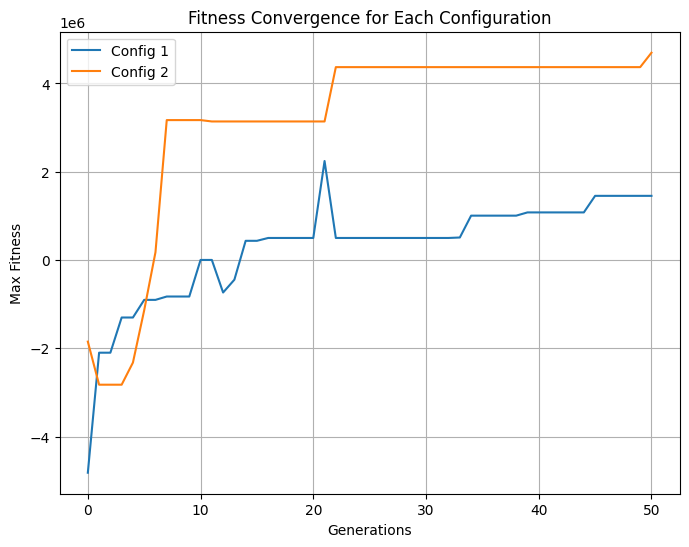

In [24]:
# Plot convergence after running the GA
grouped_runs = {}
for run in runs:
    config = tuple(run["params"])
    if config not in grouped_runs:
        grouped_runs[config] = []
    grouped_runs[config].append(run)

plt.figure(figsize=(8, 6))
for i, (config, config_runs) in enumerate(grouped_runs.items()):
    for run in config_runs:
        logbook = run["logbook"]
        generations = [record['gen'] for record in logbook]
        max_fitness = [record['max'] for record in logbook]
        plt.plot(generations, max_fitness, label=f"Config {i+1}")

plt.xlabel("Generations")
plt.ylabel("Max Fitness")
plt.title("Fitness Convergence for Each Configuration")
plt.legend()
plt.grid()
plt.show()